# Build and train image-genomin-coding

* Refer to CMC: https://github.com/HobbitLong/CMC/blob/master/train_CMC.py

* Refer to InceptionV3: https://pytorch.org/hub/pytorch_vision_inception_v3/

* Refer to more pretrained nets: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [1]:
import matplotlib.pyplot as plt
import os
import math
import numpy as np
import pandas as pd
import re
import sys

import skimage
import skimage.io
import tifffile

import time
import torch
import torch.hub
import torch.nn
# import torchvision.models  # does not work

# Self-defined functions
from alias_multinomial import AliasMethod

/project/DPDS/Xiao_lab/shared/qin_zhou/environments/envs/MicNet/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1) Load data

(25233, 27452, 3)


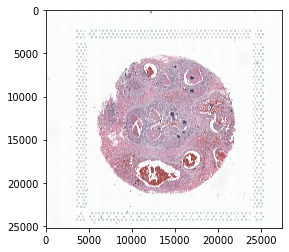

In [2]:
### Read counts
count_stat = pd.read_csv("./run/1_count_stat_breast_cancer_FFPE.csv", index_col=0)
count = pd.read_csv("./run/1_pd_count_norm_breast_cancer_FFPE.csv", index_col=0)
image_file = "./dataset/Visium_FFPE_Human_Breast_Cancer_image.tif"
image = tifffile.imread(os.path.join(image_file))
print(image.shape)
image_norm = image.copy()
plt.imshow(image_norm)
plt.show()

In [5]:
# Read position meta file
transformation_file =  "./dataset/Spot_metadata.csv"
pd_meta = pd.read_table(transformation_file, index_col=0, sep=",")
pd_meta

,Row,Col,X,Y,Spot_radius
0,,,,,
GTAGACAACCGATGAA-1,7,55,5406,13126,94
ACAGATTAGGTTAGTG-1,7,57,5407,13417,94
TGGTATCGGTCTGTAT-1,7,59,5407,13707,94
ATTATCTCGACAGATC-1,7,61,5407,13997,94
TGAGATCAAATACTCA-1,7,63,5407,14287,94
...,...,...,...,...,...
GCCCTGAGGATGGGCT-1,68,74,20805,15869,94
CGGGCGATGGATCACG-1,69,75,21057,16013,94
TGCGGACTTGACTCCG-1,68,76,20805,16159,94


In [6]:
# Split training and testing
np.random.seed(82321)
indexes_all = pd_meta.index.values
training_indexes = np.random.choice(indexes_all, int(len(indexes_all) * 0.8), replace=False)
testing_indexes = [_ for _ in indexes_all if _ not in training_indexes]
print("#Training: {}, #Testing: {}".format(len(training_indexes), len(testing_indexes)))
training_indexes.sort()
testing_indexes.sort()

#Training: 2014, #Testing: 504


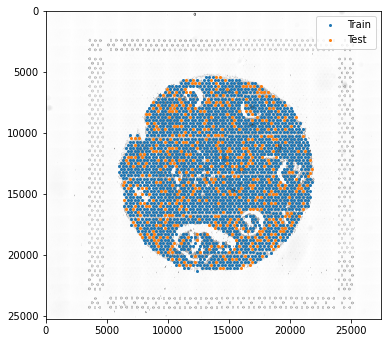

In [7]:
# Plot training & testing distribution
plt.figure(figsize=(6, 6))
plt.imshow(image_norm[..., 0], cmap="gray")
coords_x = pd_meta.loc[training_indexes, "Y"].values
coords_y = pd_meta.loc[training_indexes, "X"].values
plt.scatter(coords_x, coords_y, s=4, label="Train")
coords_x = pd_meta.loc[testing_indexes, "Y"].values
coords_y = pd_meta.loc[testing_indexes, "X"].values
plt.scatter(coords_x, coords_y, s=4, label="Test")
plt.gca().set_aspect('equal')
plt.xlim(0, image.shape[1])
plt.ylim(image.shape[0], 0)
plt.legend()
plt.show()

In [8]:
PATCH_SIZE = 256

## 2) Check data loader

In [9]:
# from utils_data import Dataset
from utils_data import normalize, augmentor

import numpy as np
import math
import skimage
import skimage.transform

import torch
import torch.utils
import torch.utils.data
    
# Get image patch
def get_image_patch(image, coords, patch_size):
    """
    Args:
        coords: center of image; x, y (col, row) in pixels
    """
    row_start = int(coords[1] - patch_size/2)
    col_start = int(coords[0] - patch_size/2)
    return image[row_start:row_start + patch_size, col_start:col_start + patch_size]

class Dataset(torch.utils.data.Dataset):
    __initialized = False
    def __init__(self, indexes, image, count_df, meta_df, augmentation=False):
        """
        Args:
            indexes: index used for both count_df and meta_df
        """
        self.indexes = indexes
        self.image = image
        self.count_df = count_df
        self.meta_df = meta_df
        self.augmentation = augmentation
        self.__initialized = True

    def __len__(self):
        """Denotes the number of samples"""
        return len(self.indexes)
    
    def __getitem__(self, index):
        """Generate one batch of data.
        
        Returns:
            index: indexes of samples (long)
        """
        # Generate data
        data = self.__data_generation(self.indexes[index])

        return data, index
    
    def __data_generation(self, indexes):
        """Generates data containing batch_size samples.
        
        Returns:
            data: a dictionary with data.image in [b, ch, h, w]; data.gene in [b, n_genes]
        """
        image = get_image_patch(self.image, 
                                [self.meta_df.loc[indexes, "Y"], self.meta_df.loc[indexes, "X"]], 
                                PATCH_SIZE)  # meta_df mistakes X/Y
        if self.augmentation:
            image = augmentor(normalize(image))
        else:
            image = normalize(image)
        
        data = dict()
        data['image'] = torch.tensor(np.transpose(image, (2, 0, 1)).astype(float))
        data['gene'] = torch.tensor(self.count_df.loc[indexes, :].values)
        
        return data 

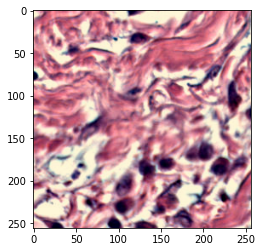

tensor([1405])


In [10]:
# Generator
np.random.seed()
train_set = Dataset(training_indexes, image_norm, count, pd_meta, augmentation=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True, num_workers=1)
for x, y in train_loader:
    plt.imshow(normalize(np.transpose(x['image'][0].numpy(), (1, 2, 0)), inverse=True))
    plt.show()
    print(y)
    break

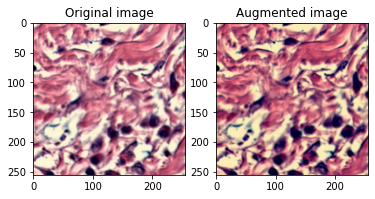

In [11]:
image = normalize(np.transpose(x['image'][0].numpy(), (1, 2, 0)), inverse=True)
plt.subplot(121)
plt.imshow(image)
plt.title("Original image")
plt.subplot(122)
plt.imshow(normalize(augmentor(normalize(image)), inverse=True))
plt.title("Augmented image")
plt.show()

## 3) Create network

In [12]:
class IGCNet(torch.nn.Module):
    def __init__(self, image_shape, n_genes, n_out_features, 
                 imagenet='resnet101', 
                 genenet=[500, 100]):
        """
        Args:
            image_shape: w/h of input image
            n_genes: number of genes to consider
            n_out_features: number of output features
            imagenet: architecture to encode image features
            genenet: architecture to encode genetic features: list of #hidden nodes
        """
        super(IGCNet, self).__init__()

        if imagenet == 'resnet101':
            # Require image size at least 224
            self.imagenet = torch.hub.load('pytorch/vision:v0.4.0', imagenet, pretrained=True)
            self.imagenet.float()
            self.imagenet.layer4[2].relu = torch.nn.ReLU6()
            self.imagenet.fc = torch.nn.Linear(self.imagenet.fc.in_features, n_out_features)
            input_size = image_shape
        elif imagenet == 'inception_v3':
            # Require image input size = 299, has auxillary output
            self.imagenet = torch.hub.load('pytorch/vision:v0.4.0', imagenet, pretrained=True)
            self.imagenet.float()
            raise("Incomplete model")
        else:
            raise("Invalid model name")

        genenet_fcs = []
        genenet_in_shape = n_genes
        for i, genenet_n_hidden_nodes in enumerate(genenet):
            genenet_fcs.append(torch.nn.Linear(genenet_in_shape, genenet_n_hidden_nodes))
            genenet_fcs.append(torch.nn.BatchNorm1d(genenet_n_hidden_nodes))
            genenet_fcs.append(torch.nn.ReLU6())
            genenet_in_shape = genenet_n_hidden_nodes
        genenet_fcs.append(torch.nn.Linear(genenet_in_shape, n_out_features))
        self.genenet_fcs = torch.nn.ModuleList(genenet_fcs)

    def forward(self, data):
        """
        Args:
            data: a dictionary
        """
        image, gene = data['image'], data['gene']
        f_image = self.imagenet(image)
        
        f_gene = gene
        for layer in self.genenet_fcs:
            f_gene = layer(f_gene)
        
        return f_image, f_gene

In [13]:
from torch.nn.modules import MSELoss
from utils_eval import NCESoftmaxLoss, NCECriterion
# from IGCmodel import IGCNet, NCEAverage
from IGCmodel import NCEAverage

device = torch.device("cuda:1")
image_shape = PATCH_SIZE
n_genes = count_stat.shape[1]
n_data = len(training_indexes)
n_out_features = 100
imagenet = 'resnet101'

# NCE parameters
# Increasing nce_m improves stability
# !!! Adding batch normalization layer improves stability 
nce_k = 100
nce_t = 0.07
nce_m = 0.9
softmax = False

# Training parameters
# Decreasing lr and adding gradient_clip improves stability
lr = 0.01   # ori 0.01
momentum = 0.9
weight_decay = 0.0001
gradient_clip = 5

# Generator
train_set = Dataset(training_indexes, image_norm, count, pd_meta, augmentation=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=20, shuffle=True, num_workers=1)
test_set = Dataset(testing_indexes, image_norm, count, pd_meta, augmentation=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=20, shuffle=False, num_workers=1)

# Set model
model = IGCNet(image_shape=image_shape, n_genes=n_genes, n_out_features=n_out_features, 
               imagenet=imagenet, genenet=[500, 100]).to(device)
contrast = NCEAverage(n_out_features, n_data, nce_k, nce_t, nce_m, softmax, device=device).to(device)
criterion_image = NCESoftmaxLoss().to(device) if softmax else NCECriterion(n_data).to(device)
criterion_gene = NCESoftmaxLoss().to(device) if softmax else NCECriterion(n_data).to(device)

# Set optimizer
optimizer = torch.optim.SGD(model.parameters(),
                            lr=lr,
                            momentum=momentum,
                            weight_decay=weight_decay)

Using cache found in /home2/s223242/.cache/torch/hub/pytorch_vision_v0.4.0


In [14]:
model_dir = "./models/2_IGC_breast_cancer_FFPE"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

In [15]:
model

IGCNet(
  (imagenet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

In [18]:
"""TO LOAD:"""
model_file = None
if model_file is not None:
    print("=> loading checkpoint '{}'".format(model_file))
    checkpoint = torch.load(model_file, map_location=device)
    start_epoch = checkpoint['epoch'] + 1
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    contrast.load_state_dict(checkpoint['contrast'])
    del checkpoint

## 4) Train

In [19]:
import time
from scipy.stats import spearmanr

from utils_eval import AverageMeter

def train(epoch, train_loader, model, contrast, criterion_image, criterion_gene, optimizer, 
          gradient_clip=10, print_freq=1, device=torch.device("cuda:0")):
    """
    One epoch training
    """
    model.train()
    contrast.train()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    image_loss_meter = AverageMeter()
    gene_loss_meter = AverageMeter()
    image_prob_meter = AverageMeter()
    gene_prob_meter = AverageMeter()

    end = time.time()
    for idx, (data, index) in enumerate(train_loader):
        data_time.update(time.time() - end)

        batch_size = data['image'].size(0)
        index = index.to(device)
        for _ in data.keys():
            data[_] = data[_].float().to(device)

        # ===================forward=====================
        feat_image, feat_gene = model(data)
        out_image, out_gene = contrast(feat_image, feat_gene, index)
        
        # print("features:", feat_image, feat_gene, "\n")
        # print("outs: ", out_image, out_gene, "\n")
        
        image_loss = criterion_image(out_image)
        gene_loss = criterion_gene(out_gene)
        image_prob = out_image[:, 0].mean()
        gene_prob = out_gene[:, 0].mean()

        loss = image_loss + gene_loss

        # ===================backward=====================
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
        torch.nn.utils.clip_grad_norm_(contrast.parameters(), gradient_clip)
        optimizer.step()

        # ===================meters=====================
        losses.update(loss.item(), batch_size)
        image_loss_meter.update(image_loss.item(), batch_size)
        image_prob_meter.update(image_prob.item(), batch_size)
        gene_loss_meter.update(gene_loss.item(), batch_size)
        gene_prob_meter.update(gene_prob.item(), batch_size)

        torch.cuda.synchronize()
        batch_time.update(time.time() - end)
        end = time.time()

        # print info
        if (idx + 1) % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  # 'BT {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  # 'DT {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'loss {loss.val:.3f} ({loss.avg:.3f})\t'
                  'image_p {image_probs.val:.3f} ({image_probs.avg:.3f})\t'
                  'gene_p {gene_probs.val:.3f} ({gene_probs.avg:.3f})'.format(
                   epoch, idx + 1, len(train_loader), batch_time=batch_time,
                   data_time=data_time, 
                   loss=losses, 
                   image_probs=image_prob_meter,
                   gene_probs=gene_prob_meter))
            # print(out_image.shape)
            sys.stdout.flush()
            
        # ===================debug======================
        if np.isnan(image_prob_meter.val):
            print(list(model.parameters()))
            print(feat_image)
            print(feat_gene)
            print(out_image)
            
            raise Exception("Nan detected")
            break

    return losses.avg, image_loss_meter.avg, image_prob_meter.avg, gene_loss_meter.avg, gene_prob_meter.avg


def test(epoch, test_loader, model, contrast, criterion_image, criterion_gene, optimizer, 
          gradient_clip=10, print_freq=1, device=torch.device("cuda:0")):
    """Testing"""
    model.eval()
    contrast.eval()

    batch_time = AverageMeter()
    data_time = AverageMeter()

    end = time.time()
    for idx, (data, index) in enumerate(test_loader):
        data_time.update(time.time() - end)

        batch_size = data['image'].size(0)
        index = index.to(device)
        for _ in data.keys():
            data[_] = data[_].float().to(device)

        # ===================forward=====================
        with torch.no_grad():
            feat_image, feat_gene = model(data)
        
        # Append
        if idx == 0:
            feat_images = feat_image.cpu().numpy()
            feat_genes = feat_gene.cpu().numpy()
        else:
            feat_images = np.concatenate([feat_images, feat_image.cpu().numpy()])
            feat_genes = np.concatenate([feat_genes, feat_gene.cpu().numpy()])
        
        torch.cuda.synchronize()
        batch_time.update(time.time() - end)
        end = time.time()
        
    # Normalize & calculate correlation
    feat_images = feat_images / np.sum(feat_images ** 2, axis=1, keepdims=True) ** 0.5
    feat_genes = feat_genes / np.sum(feat_genes ** 2, axis=1, keepdims=True) ** 0.5
    corr = []
    for i in range(feat_images.shape[1]):
        corr.append(spearmanr(feat_images[:, i], feat_genes[:, i]).correlation)
    if epoch % 100 == 0:
        plt.hist(corr, bins=30)
        plt.show()
    print("Val epoch {}, average corr {}".format(epoch, np.average(corr)))

    return np.average(corr)

Epoch: [0][10/101]	loss 39.470 (39.675)	image_p 0.009 (0.010)	gene_p 0.010 (0.010)
Epoch: [0][20/101]	loss 36.655 (38.836)	image_p 0.004 (0.010)	gene_p 0.009 (0.010)
Epoch: [0][30/101]	loss 33.554 (37.167)	image_p 0.011 (0.012)	gene_p 0.011 (0.010)
Epoch: [0][40/101]	loss 32.718 (36.255)	image_p 0.000 (0.010)	gene_p 0.012 (0.010)
Epoch: [0][50/101]	loss 30.566 (35.499)	image_p 0.003 (0.009)	gene_p 0.018 (0.011)
Epoch: [0][60/101]	loss 30.590 (34.632)	image_p 0.009 (0.012)	gene_p 0.016 (0.013)
Epoch: [0][70/101]	loss 25.401 (33.685)	image_p 0.038 (0.014)	gene_p 0.032 (0.015)
Epoch: [0][80/101]	loss 24.526 (32.665)	image_p 0.102 (0.018)	gene_p 0.033 (0.017)
Epoch: [0][90/101]	loss 20.453 (31.493)	image_p 0.060 (0.022)	gene_p 0.055 (0.022)
Epoch: [0][100/101]	loss 14.844 (30.021)	image_p 0.161 (0.033)	gene_p 0.250 (0.035)


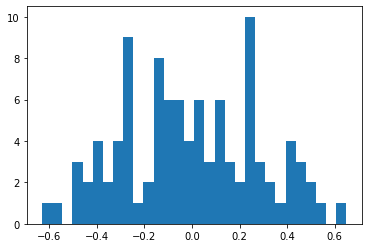

Val epoch 0, average corr -0.006376804681414567
New best corr_val: -0.0064 at epoch 0, model saved.
Epoch: [1][10/101]	loss 29.377 (29.263)	image_p 0.025 (0.015)	gene_p 0.002 (0.014)
Epoch: [1][20/101]	loss 26.949 (28.202)	image_p 0.017 (0.016)	gene_p 0.028 (0.016)
Epoch: [1][30/101]	loss 27.006 (27.713)	image_p 0.006 (0.017)	gene_p 0.028 (0.019)
Epoch: [1][40/101]	loss 23.991 (26.942)	image_p 0.013 (0.019)	gene_p 0.003 (0.022)
Epoch: [1][50/101]	loss 22.560 (26.265)	image_p 0.039 (0.020)	gene_p 0.064 (0.023)
Epoch: [1][60/101]	loss 20.842 (25.535)	image_p 0.055 (0.024)	gene_p 0.004 (0.025)
Epoch: [1][70/101]	loss 20.009 (24.858)	image_p 0.031 (0.026)	gene_p 0.006 (0.026)
Epoch: [1][80/101]	loss 18.746 (24.283)	image_p 0.076 (0.030)	gene_p 0.129 (0.028)
Epoch: [1][90/101]	loss 16.807 (23.567)	image_p 0.143 (0.038)	gene_p 0.071 (0.032)
Epoch: [1][100/101]	loss 9.950 (22.555)	image_p 0.466 (0.057)	gene_p 0.427 (0.048)
Val epoch 1, average corr 0.2512219646126594
New best corr_val: 0.2512

Epoch: [9][100/101]	loss 8.581 (21.022)	image_p 0.644 (0.128)	gene_p 0.309 (0.089)
Val epoch 9, average corr 0.3381087789329221
Saving model checkpoint...
Epoch: [10][10/101]	loss 23.336 (25.153)	image_p 0.071 (0.049)	gene_p 0.082 (0.050)
Epoch: [10][20/101]	loss 23.627 (24.966)	image_p 0.078 (0.050)	gene_p 0.034 (0.046)
Epoch: [10][30/101]	loss 24.652 (24.645)	image_p 0.021 (0.051)	gene_p 0.042 (0.048)
Epoch: [10][40/101]	loss 21.826 (23.993)	image_p 0.065 (0.055)	gene_p 0.027 (0.048)
Epoch: [10][50/101]	loss 20.982 (23.584)	image_p 0.100 (0.062)	gene_p 0.148 (0.051)
Epoch: [10][60/101]	loss 17.747 (22.972)	image_p 0.130 (0.070)	gene_p 0.182 (0.056)
Epoch: [10][70/101]	loss 16.746 (22.307)	image_p 0.134 (0.082)	gene_p 0.113 (0.064)
Epoch: [10][80/101]	loss 15.587 (21.537)	image_p 0.128 (0.096)	gene_p 0.266 (0.077)
Epoch: [10][90/101]	loss 12.391 (20.784)	image_p 0.302 (0.111)	gene_p 0.327 (0.091)
Epoch: [10][100/101]	loss 7.188 (19.658)	image_p 0.764 (0.147)	gene_p 0.438 (0.120)
Val e

Epoch: [18][80/101]	loss 15.866 (17.633)	image_p 0.303 (0.185)	gene_p 0.075 (0.094)
Epoch: [18][90/101]	loss 11.517 (17.277)	image_p 0.476 (0.211)	gene_p 0.197 (0.098)
Epoch: [18][100/101]	loss 12.067 (16.846)	image_p 0.727 (0.246)	gene_p 0.197 (0.101)
Val epoch 18, average corr 0.614815811558651
New best corr_val: 0.6148 at epoch 18, model saved.
Saving model checkpoint...
Epoch: [19][10/101]	loss 19.265 (18.499)	image_p 0.114 (0.118)	gene_p 0.098 (0.151)
Epoch: [19][20/101]	loss 17.193 (18.215)	image_p 0.046 (0.130)	gene_p 0.286 (0.134)
Epoch: [19][30/101]	loss 16.698 (17.828)	image_p 0.202 (0.138)	gene_p 0.114 (0.133)
Epoch: [19][40/101]	loss 15.327 (17.829)	image_p 0.146 (0.138)	gene_p 0.147 (0.126)
Epoch: [19][50/101]	loss 18.489 (17.609)	image_p 0.161 (0.145)	gene_p 0.097 (0.131)
Epoch: [19][60/101]	loss 18.449 (17.252)	image_p 0.139 (0.154)	gene_p 0.102 (0.135)
Epoch: [19][70/101]	loss 14.361 (16.797)	image_p 0.258 (0.168)	gene_p 0.192 (0.145)
Epoch: [19][80/101]	loss 11.252 (16

Epoch: [27][50/101]	loss 14.354 (14.541)	image_p 0.167 (0.216)	gene_p 0.242 (0.188)
Epoch: [27][60/101]	loss 11.914 (14.449)	image_p 0.449 (0.230)	gene_p 0.281 (0.188)
Epoch: [27][70/101]	loss 12.827 (14.198)	image_p 0.347 (0.247)	gene_p 0.328 (0.190)
Epoch: [27][80/101]	loss 10.173 (13.836)	image_p 0.570 (0.271)	gene_p 0.186 (0.192)
Epoch: [27][90/101]	loss 10.432 (13.475)	image_p 0.540 (0.301)	gene_p 0.233 (0.198)
Epoch: [27][100/101]	loss 6.736 (12.973)	image_p 0.768 (0.341)	gene_p 0.336 (0.208)
Val epoch 27, average corr 0.6533881905538708
Saving model checkpoint...
Epoch: [28][10/101]	loss 12.829 (14.936)	image_p 0.235 (0.223)	gene_p 0.309 (0.181)
Epoch: [28][20/101]	loss 15.021 (14.815)	image_p 0.180 (0.223)	gene_p 0.176 (0.189)
Epoch: [28][30/101]	loss 15.551 (14.982)	image_p 0.144 (0.228)	gene_p 0.099 (0.174)
Epoch: [28][40/101]	loss 14.231 (14.743)	image_p 0.234 (0.230)	gene_p 0.216 (0.177)
Epoch: [28][50/101]	loss 12.998 (14.476)	image_p 0.258 (0.240)	gene_p 0.199 (0.180)
Epo

Epoch: [36][40/101]	loss 13.281 (12.622)	image_p 0.244 (0.307)	gene_p 0.175 (0.237)
Epoch: [36][50/101]	loss 10.831 (12.247)	image_p 0.526 (0.328)	gene_p 0.188 (0.246)
Epoch: [36][60/101]	loss 14.095 (12.071)	image_p 0.238 (0.340)	gene_p 0.130 (0.252)
Epoch: [36][70/101]	loss 6.741 (11.793)	image_p 0.655 (0.363)	gene_p 0.510 (0.254)
Epoch: [36][80/101]	loss 8.707 (11.504)	image_p 0.514 (0.381)	gene_p 0.263 (0.264)
Epoch: [36][90/101]	loss 7.333 (11.172)	image_p 0.594 (0.403)	gene_p 0.402 (0.278)
Epoch: [36][100/101]	loss 7.606 (10.708)	image_p 0.698 (0.440)	gene_p 0.335 (0.291)
Val epoch 36, average corr 0.6571152759701822
Saving model checkpoint...
Epoch: [37][10/101]	loss 13.074 (13.940)	image_p 0.395 (0.257)	gene_p 0.226 (0.189)
Epoch: [37][20/101]	loss 11.209 (13.339)	image_p 0.413 (0.302)	gene_p 0.255 (0.198)
Epoch: [37][30/101]	loss 13.606 (13.036)	image_p 0.409 (0.318)	gene_p 0.259 (0.206)
Epoch: [37][40/101]	loss 11.893 (12.839)	image_p 0.329 (0.334)	gene_p 0.287 (0.212)
Epoch:

Epoch: [45][50/101]	loss 9.805 (11.539)	image_p 0.421 (0.334)	gene_p 0.278 (0.261)
Epoch: [45][60/101]	loss 11.711 (11.267)	image_p 0.418 (0.353)	gene_p 0.286 (0.270)
Epoch: [45][70/101]	loss 10.314 (11.283)	image_p 0.564 (0.365)	gene_p 0.264 (0.266)
Epoch: [45][80/101]	loss 9.066 (11.095)	image_p 0.647 (0.387)	gene_p 0.217 (0.265)
Epoch: [45][90/101]	loss 4.387 (10.832)	image_p 0.866 (0.412)	gene_p 0.536 (0.271)
Epoch: [45][100/101]	loss 5.941 (10.460)	image_p 0.779 (0.443)	gene_p 0.549 (0.288)
Val epoch 45, average corr 0.5729876019695126
Saving model checkpoint...
Epoch: [46][10/101]	loss 14.562 (12.520)	image_p 0.277 (0.296)	gene_p 0.214 (0.238)
Epoch: [46][20/101]	loss 11.881 (12.000)	image_p 0.243 (0.317)	gene_p 0.297 (0.275)
Epoch: [46][30/101]	loss 10.018 (11.459)	image_p 0.422 (0.348)	gene_p 0.490 (0.288)
Epoch: [46][40/101]	loss 11.832 (11.289)	image_p 0.358 (0.365)	gene_p 0.224 (0.291)
Epoch: [46][50/101]	loss 9.515 (10.949)	image_p 0.535 (0.384)	gene_p 0.165 (0.293)
Epoch: 

In [20]:

hist = dict()
hist['loss'] = []
hist['corr_val'] = []
hist['image_loss'] = []
hist['image_prob'] = []
hist['gene_loss'] = []
hist['gene_prob'] = []
hist_best = dict()
best_corr = -float("inf")  

save_freq = 1
for epoch in range(50):
    loss, image_loss, image_prob, gene_loss, gene_prob = \
        train(epoch, train_loader, model, contrast, criterion_image, criterion_gene, optimizer, 
              gradient_clip=gradient_clip, print_freq=10, device=device)
    hist['loss'].append(loss)
    hist['image_loss'].append(image_loss)
    hist['image_prob'].append(image_prob)
    hist['gene_loss'].append(gene_loss)
    hist['gene_prob'].append(gene_prob)
    
    corr = test(epoch, test_loader, model, contrast, criterion_image, criterion_gene, optimizer, 
              gradient_clip=gradient_clip, print_freq=10, device=device)
    hist['corr_val'].append(corr)

    # Check if this is the best corr so far
    if corr > best_corr:
        best_corr = corr
        hist_best = {
            'model': model.state_dict(),
            'contrast': contrast.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch,
            'corr_val': corr
        }
        torch.save(hist_best, os.path.join(model_dir, "hist_best.pt"))
        print(f"New best corr_val: {best_corr:.4f} at epoch {epoch}, model saved.")

    # Regular save by frequency
    if epoch % save_freq == 0 and epoch != 0:
        print("Saving model checkpoint...")
        state = { 'model': model.state_dict(),
                  'contrast': contrast.state_dict(),
                  'optimizer': optimizer.state_dict(),
                  'epoch': epoch }
        torch.save(state, os.path.join(model_dir, f"epoch_{epoch}.pt"))

# Save full history at the end
torch.save(hist, os.path.join(model_dir, "hist.pt"))


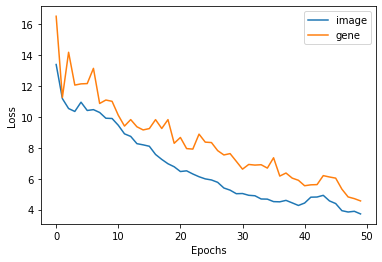

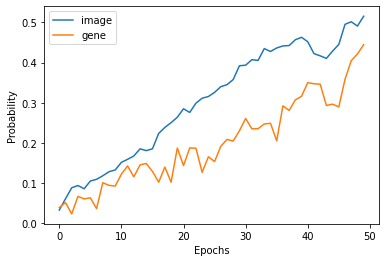

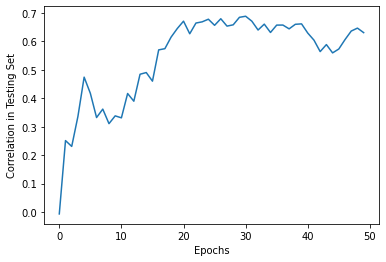

In [22]:
plt.plot(np.arange(len(hist['image_loss'])), hist['image_loss'])
plt.plot(np.arange(len(hist['gene_loss'])), hist['gene_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["image", "gene"])
plt.show()
plt.plot(np.arange(len(hist['image_prob'])), hist['image_prob'])
plt.plot(np.arange(len(hist['gene_prob'])), hist['gene_prob'])
plt.xlabel("Epochs")
plt.ylabel("Probability")
plt.legend(["image", "gene"])
plt.show()
plt.plot(hist['corr_val'])
plt.xlabel("Epochs")
plt.ylabel("Correlation in Testing Set")
plt.show()

In [23]:
np.argmax(hist['corr_val'])

30

# Session Info

In [58]:
!pip freeze

absl-py==0.7.0
adjustText==0.7.3
altair==3.2.0
anndata==0.7.5
argh==0.26.2
ase==3.21.1
astor==0.7.1
astropy==3.2.1
atomicwrites==1.3.0
attrs==19.1.0
autograd==1.3
autograd-gamma==0.5.0
backcall==0.1.0
base58==1.0.3
bleach==1.5.0
blinker==1.4
boto3==1.10.15
botocore==1.13.15
Bottleneck==1.2.1
cachetools==4.1.0
certifi==2019.3.9
chardet==3.0.4
Click==7.0
cvxopt==1.2.3
cvxpy==1.0.24
cycler==0.10.0
Cython==0.29.15
dataclasses==0.8
decorator==4.4.0
defusedxml==0.5.0
dill==0.2.9
docutils==0.15.2
ecos==2.0.7.post1
entrypoints==0.3
enum-compat==0.0.3
environment-kernels==1.1.1
FITS-tools==0.2
formulaic==0.2.4
future==0.17.1
gast==0.2.2
get-version==2.1
google-auth==1.14.3
google-auth-oauthlib==0.4.1
google-pasta==0.2.0
googledrivedownloader==0.4
grpcio==1.29.0
h5py==2.10.0
html5lib==0.9999999
idna==2.8
image-registration==0.2.4
imageio==2.6.1
importlib-metadata==0.23
interface-meta==1.2.3
ipykernel==5.1.0
ipython==7.4.0
ipython-genutils==0.2.0
ipywidgets==7.4.2
isodate==0.6.0
jedi==0.13.3
Jinj